In [35]:

# import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.random import set_seed

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input


In [41]:

# for reproducibility
set_seed(0)

# PASSENGER_DATA = os.path.join(os.path.dirname(__file__), "passengers.csv")
PASSENGER_DATA = "./passengers.csv"

# load the dataset
passengers = pd.read_csv(PASSENGER_DATA, 
                         header=0,
                         usecols=[1],
                         dtype="float32")


In [43]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    
    X,Y = [], []
    for i in range(len(dataset)-look_back-1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
        
    return np.array(X), np.array(Y)

def preprocessing(data, look_back=1, title="Airplane Passengers", xaxis="Date", yaxis="# Passengers"):
    
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

    # split into train and test sets
    train_size = int(len(data)*0.7)
    train, test = data[0:train_size], data[train_size:]

    # reshape into X=t and Y=t+1
    x_train, y_train = create_dataset(train, look_back)
    x_test, y_test = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    return x_test, x_train, y_test, y_train

def create_model(look_back=1):
    
    # create the LSTM network model
    model = Sequential(name="LTSM")
    
    # Add an LSTM layer with an input shape (time steps, features per step)
    model.add(Input(shape=(look_back, 1)))
    
    # Add an LSTM layer
    model.add(LSTM(10))  # Assuming '10' as the number of LSTM units

    # model.add(Dense(8))  # Uncomment this if you want an additional Dense layer
    model.add(Dense(1))  # Output layer with one neuron for regression output
    
    model.summary()
    
    return model

def _plot(historical_loss, baseline, p_train_plot, p_test_plot):
    
    _, (ax1, ax2) = plt.subplots(2,1, layout="tight")
    
    # plot historical loss
    ax1.plot(historical_loss, label='loss')
    ax1.set_title("Mean Squared Error per Epoch")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error')
    ax1.legend()
    ax1.grid(True)
    
    # plot baseline and predictions
    ax2.plot(baseline, label="Ground Truth")
    ax2.plot(p_train_plot, label="Train Prediction")
    ax2.plot(p_test_plot, label="Test Prediction")
    ax2.set_title("Model Performance")
    ax2.set_ylabel("# Passengers")
    ax2.set_xlabel("Date")
    # ax2.legend(["Ground Truth", "Train Prediction", "Test Prediction"])
    
    plt.show()
    
def fit_model(model, x_train, y_train, learning_rate=0.001, epochs=50):
    
    # compile model with Adam optimizer and MSE
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(learning_rate=learning_rate)
                  )
    
    # fit model
    history = model.fit(x_train, y_train, epochs=epochs, verbose=0)
    return history

def make_prediction(model, x_train, x_test):
    # make predictions
    return model.predict(x_train), model.predict(x_test)

def evaluate_prediction(ground_truth, y_train, y_test, p_train, p_test, look_back=1):
    
    # calculate root mean squared error
    train_score = np.sqrt(mean_squared_error(y_train[0], p_train[:,0]))
    test_Score = np.sqrt(mean_squared_error(y_test[0], p_test[:,0]))
    print(f'Train Score: {train_score:.2f} RMSE',
          f'Test Score: {test_Score:.2f} RMSE')

    # shift train predictions for plotting
    p_train_plot = np.empty_like(ground_truth)
    p_train_plot[:, :] = np.nan
    p_train_plot[look_back:len(p_train)+look_back, :] = p_train

    # shift test predictions for plotting
    p_test_plot = np.empty_like(ground_truth)
    p_test_plot[:, :] = np.nan
    p_test_plot[len(p_train)+(look_back*2)+1:len(ground_truth)-1, :] = p_test

    return p_train_plot, p_test_plot

def fit_and_predict(model, passengers, n_fittings=3):
    
    # normalize the dataset from 0 to 1
    scaler = MinMaxScaler()
    passengers = scaler.fit_transform(passengers.values)
    
    # split into train and test sets
    x_test, x_train, y_test, y_train = preprocessing(passengers)
    
    for _ in range(n_fittings):
        # compile and fit 
        history = fit_model(model, x_train, y_train)
        historical_loss = history.history['loss']

        # make predictions
        p_train, p_test = make_prediction(model, x_train, x_test)
        
        # invert predictions
        p_train = scaler.inverse_transform(p_train)
        y_train_inv = scaler.inverse_transform([y_train])
        p_test = scaler.inverse_transform(p_test)
        y_test_inv = scaler.inverse_transform([y_test])
        
        # evaluate predictions
        baseline = scaler.inverse_transform(passengers)
        p_train_plot, p_test_plot = evaluate_prediction(passengers, y_train_inv, y_test_inv, p_train, p_test)
        
        # plot result
        _plot(historical_loss, baseline, p_train_plot, p_test_plot)


Model: "LTSM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

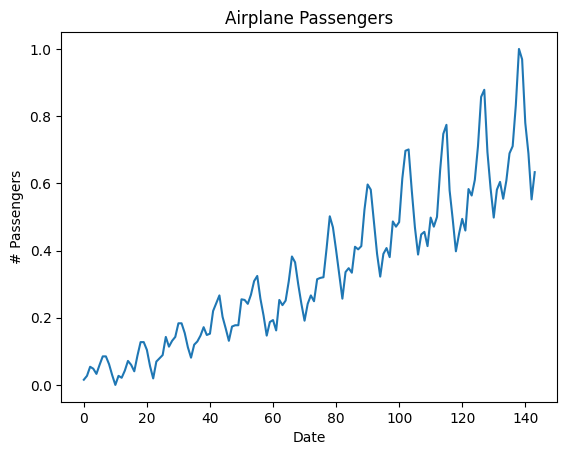

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 63.94 RMSE Test Score: 191.09 RMSE


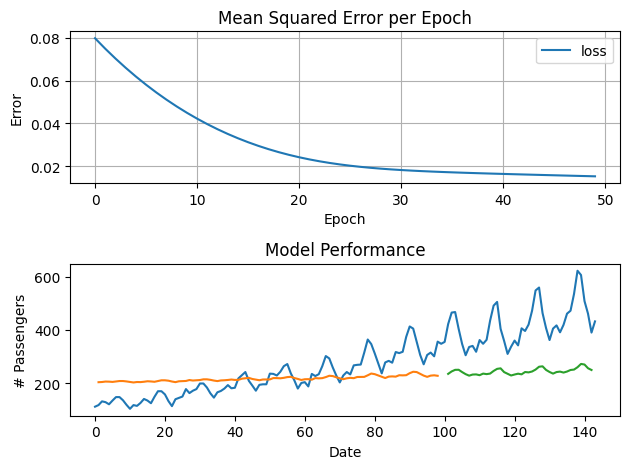

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 42.69 RMSE Test Score: 116.06 RMSE


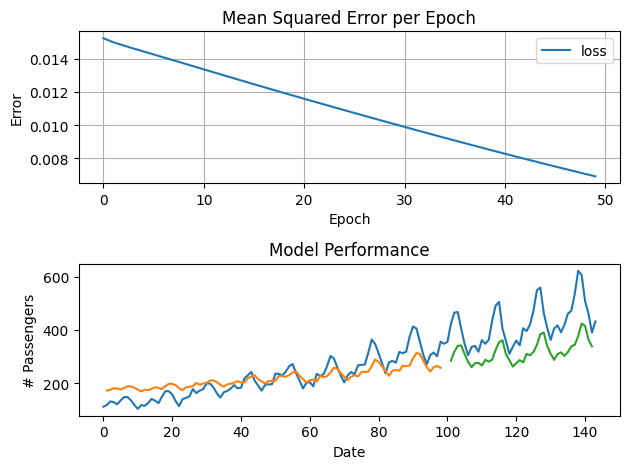

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 24.31 RMSE Test Score: 51.11 RMSE


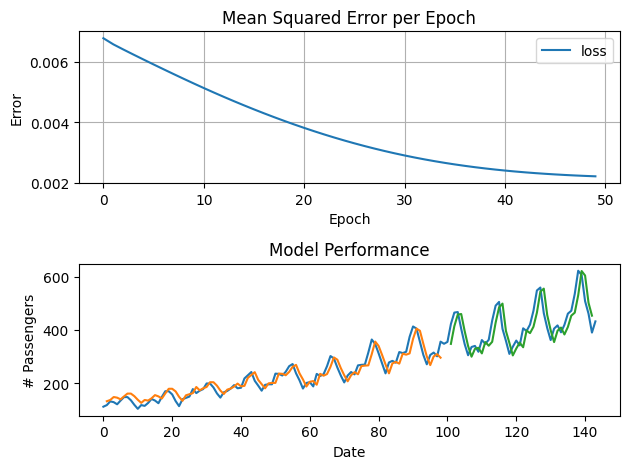

In [44]:

# create the LSTM network model
model = create_model()

# fit with dataset and predict
fit_and_predict(model, passengers)
